# Анализ улучшений мобильного приложения по доставке продуктов

Имеются данные о продажах интернет-магазина продуктов питания через мобильное приложение, нужно изучить воронку продаж и определить узкие места. Изучить результаты А/А/В-тестирования измененного шрифта в приложении и выяснить как измененный шрифт повлиял на продажи.

In [1]:
# Загрузим необходимые библиотеки
import pandas as pd
from datetime import date
from plotly import graph_objects as go
import math as mth
from scipy import stats as st
import matplotlib.pyplot as plt

# Определим ширину визуализации и количество разрядов.
pd.set_option('display.max_colwidth', 350)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format','{:.2f}'.format)

## Загрузим датасет.
Изучим общуюю информацию

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Яндекс Практикум /10. Сборный проект 2/сборный проект 2.csv', sep='\t')


In [3]:
# Для вывода общей информации применим функцию info_output
def info_output(data):
 
  return (print('Информация о датасете'),
         display(data.info()),
         print('----------------------------------------------------'),
         print('Первые строки датасета'),
         display(data.head()),
         print('----------------------------------------------------'),
         print('Количество пропусков по столбцам'),
         display(data.isna().sum()),
         print('----------------------------------------------------'),
         print('Количество дубликатов: {0:.0f}'.format(df.duplicated().sum())),
         print('Доля дубликатов: {0:.3%}'.format((df.duplicated().sum()/df['DeviceIDHash'].count())))
         )
  

In [4]:
# Передадим функции датасет df
info_output(df)

Информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

----------------------------------------------------
Первые строки датасета


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


----------------------------------------------------
Количество пропусков по столбцам


EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

----------------------------------------------------
Количество дубликатов: 413
Доля дубликатов: 0.169%


(None, None, None, None, None, None, None, None, None, None, None)

В представленном датасете 4 столбца и 244126 строк, пропуски в данных отсутствуют, дубликатов 143, доля дубликатов 0,169 %. Столбец EventName в формате object, остальные в формате int64.  
В столбце EventTimestamp время представлено в формате UTC, добавим новый столбец и преведем время в привычный нам вид.  


## Предобработка данных.

In [5]:
# Для удобства переименуем столбцы и приведем строковые данные к нижнему регистру.
df.columns=['event_name', 'user_id','time_stamp', 'group']
df['event_name'] = df['event_name'].str.lower()

In [6]:
# Изменим названия групп экспериментов
d = {246: 'A_1', 247: 'A_2', 248: 'B'}
df['group'] = df['group'].map(d)

In [7]:
# В столбце date_time сохраним дату и время в привычном нам формате 
df['date_time'] = pd.to_datetime(df['time_stamp'], unit='s')
# В столбце dates сохраним только дату 
df['dates']=pd.to_datetime(df['date_time']).dt.date
df.head()

,event_name,user_id,time_stamp,group,date_time,dates
0,mainscreenappear,4575588528974610257,1564029816,A_1,2019-07-25 04:43:36,2019-07-25
1,mainscreenappear,7416695313311560658,1564053102,A_1,2019-07-25 11:11:42,2019-07-25
2,paymentscreensuccessful,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
3,cartscreenappear,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
4,paymentscreensuccessful,6217807653094995999,1564055322,B,2019-07-25 11:48:42,2019-07-25


In [8]:
# Удалим дубликаты
df=df.drop_duplicates().reset_index(drop=True)
print('Количество дубликатов: {0:.0f}'.format(df.duplicated().sum()))
print('Доля дубликатов: {0:.3%}'.format((df.duplicated().sum()/df['user_id'].count())))

Количество дубликатов: 0
Доля дубликатов: 0.000%


In [9]:
df['event_name']. count()

243713

 В ходе предобработки изменили названия столбцов, перевели данные в столбце event_name в нижний регистр, перевели дату в привычный нам формат и сохранили в отдельном столбце, выделили только дату и сохранили в отдельном столбце, удалили дудликаты, после удаления дубликатов осталось 243713 строк.

## Изучим данные

In [10]:
print('Количество уникальных событий: {0:.0f}'.format(df['event_name'].nunique()))
event = df['event_name']. count()
print('Общее количество событий: {0:.0f}'.format(event))
users = df['user_id'].nunique()
print('Количество уникальных пользователей: {0:.0f}'.format(users))
print('Среднее количество событий одного пользователя: {0:.2f}'.format(event/users))

Количество уникальных событий: 5
Общее количество событий: 243713
Количество уникальных пользователей: 7551
Среднее количество событий одного пользователя: 32.28


Посмотрим на характер распределения пользователей, построим гистограмму </font>

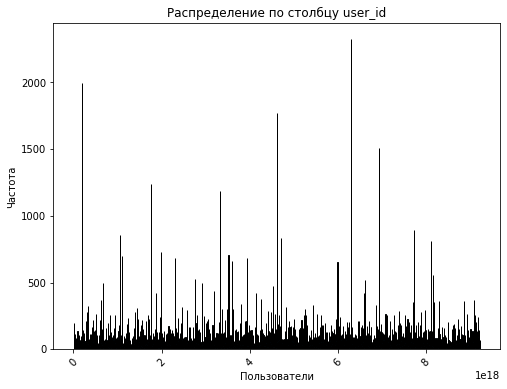

In [11]:
plt.figure(figsize =(8, 6))
df['user_id'].hist(bins=7000, edgecolor='black')
plt.title('Распределение по столбцу user_id')
plt.xlabel('Пользователи')
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.grid()
plt.show()

Есть несколько очень активных пользователей пользователей </font>

In [12]:
# подсчитаем количество событий каждого пользователя
user = df['user_id'].value_counts().reset_index()
user

,index,user_id
0,6304868067479728361,2307
1,197027893265565660,1998
2,4623191541214045580,1768
3,6932517045703054087,1439
4,1754140665440434215,1221
...,...,...
7546,6888746892508752,1
7547,6671109879025379318,1
7548,1223708690315846789,1
7549,5229230634268921313,1


In [13]:
user['user_id'].describe()

count   7551.00
mean      32.28
std       65.15
min        1.00
25%        9.00
50%       20.00
75%       37.00
max     2307.00
Name: user_id, dtype: float64

Максимальное количество заказов на одного пользователя - 2307<br>
минмальное - 1 <br>
среднее - 32,28 <br>
медианное - 20 <br>
у 25% пользователей больше 37 заказов</font>

In [14]:
# Определим временные рамки эксперимента
print('Дата начала эксперимента: {}'.format(df['dates'].min()))
print('Дата окончания эксперимента: {}'.format(df['dates'].max()))
print('Продолжительность эксперимента: {}'.format(df['date_time'].max()-df['date_time'].min()))

Дата начала эксперимента: 2019-07-25
Дата окончания эксперимента: 2019-08-07
Продолжительность эксперимента: 13 days 16:31:41


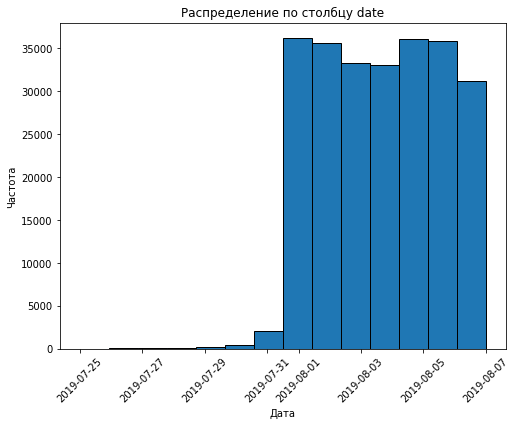

In [15]:
# Пострим гистограмму для наглядности распределения событий по дням
plt.figure(figsize =(8, 6))
df['dates'].hist(bins=14, edgecolor='black')
plt.title('Распределение по столбцу date')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.grid()
plt.show()

Построим гистограмму по столбцу date_time

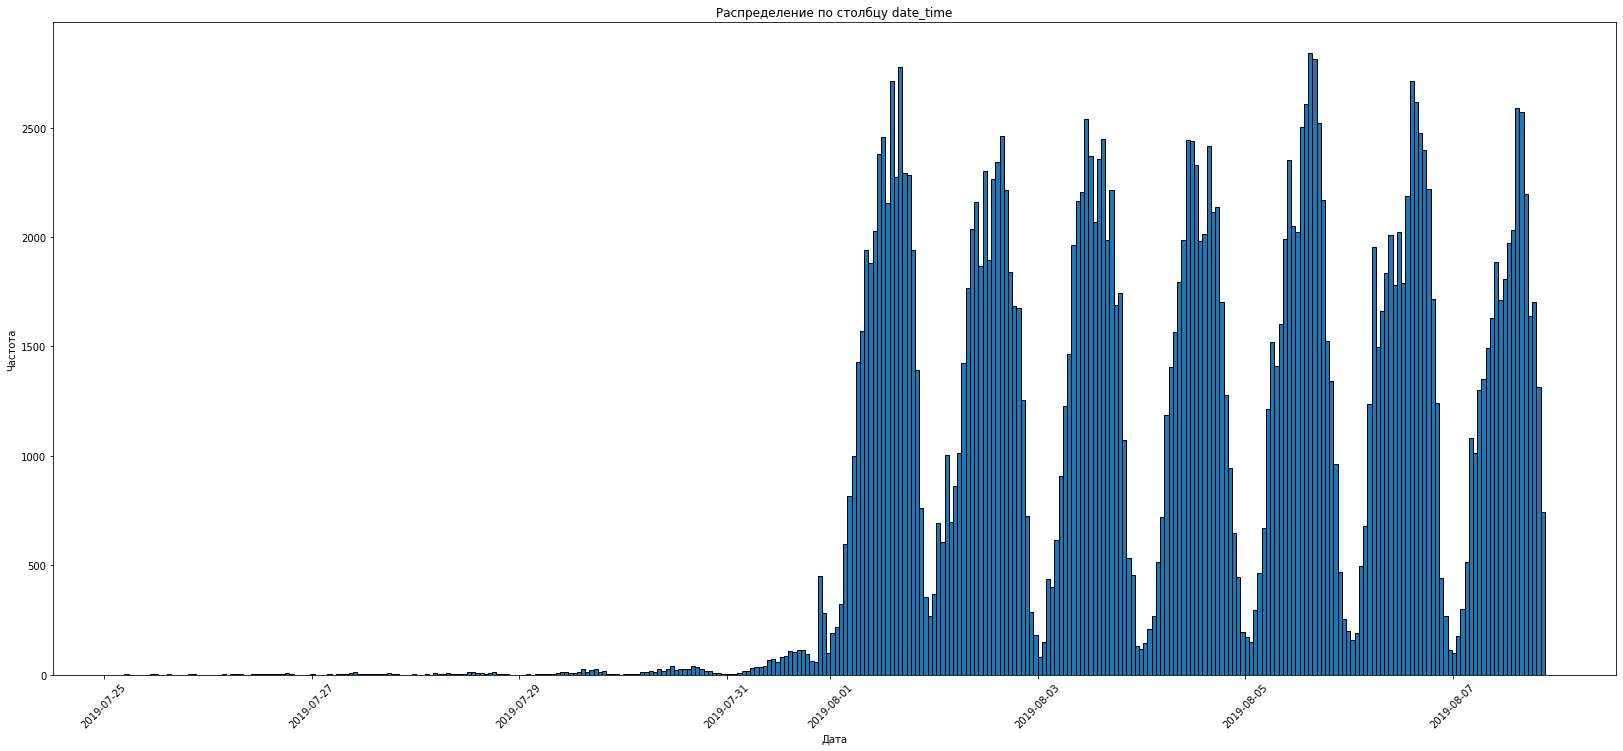

In [16]:
plt.figure(figsize =(28,12))
df['date_time'].hist(bins=336, edgecolor='black')
plt.title('Распределение по столбцу date_time')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.grid()
plt.show()

<br> По гистограмме можно увидеть, что хоть эксперимент и начался 25 июля, более-менее активно пользователи начали включаться только к вечеру 26 июля, а на точку близкую к максимуму вышли только к полудню 1 августа. 1 августа 2019 - четверг. Максимальное количество пользователей пришлось на полдень четверга и понедельника. <br>
    

In [17]:
# Посчитаем количество событий по дням
df['dates'].value_counts().reset_index().sort_values('index')

,index,dates
13,2019-07-25,9
12,2019-07-26,31
11,2019-07-27,55
10,2019-07-28,105
9,2019-07-29,184
8,2019-07-30,412
7,2019-07-31,2030
0,2019-08-01,36141
3,2019-08-02,35554
4,2019-08-03,33282


В эксперименте произведено 243713 событий 5 видов, 7551 пользователем. В среднем каждый пользователь провел почти 32 события.  
Эксперимент длился 14 дней, начался 25 июля 2019 года и закончился 7 августа того же года.
По гистограмме видно, что первую неделю эксперимента событий было гораздо меньше и их количество значительно различалось по дням, чем во вторую неделю. Во вторую неделю эксперимента количество событий по дням было примерно равное.  
Дальнейший анализ будем проводить на данных с 1 августа 2019 года.

In [18]:
# Отфильтруем датасет по дате.
df = df[df.dates > date(2019, 7, 31)].copy()
df

,event_name,user_id,time_stamp,group,date_time,dates
2826,tutorial,3737462046622621720,1564618048,A_1,2019-08-01 00:07:28,2019-08-01
2827,mainscreenappear,3737462046622621720,1564618080,A_1,2019-08-01 00:08:00,2019-08-01
2828,mainscreenappear,3737462046622621720,1564618135,A_1,2019-08-01 00:08:55,2019-08-01
2829,offersscreenappear,3737462046622621720,1564618138,A_1,2019-08-01 00:08:58,2019-08-01
2830,mainscreenappear,1433840883824088890,1564618139,A_2,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
243708,mainscreenappear,4599628364049201812,1565212345,A_2,2019-08-07 21:12:25,2019-08-07
243709,mainscreenappear,5849806612437486590,1565212439,A_1,2019-08-07 21:13:59,2019-08-07
243710,mainscreenappear,5746969938801999050,1565212483,A_1,2019-08-07 21:14:43,2019-08-07
243711,mainscreenappear,5746969938801999050,1565212498,A_1,2019-08-07 21:14:58,2019-08-07


In [19]:
print('Потеренное количество событий: {0:.2%}'.format((event-(df['event_name']. count()))/event))
print('Потеренное количество уникальных пользователей: {0:.2%}'.format((users-(df['user_id'].nunique()))/users))
print('Среднее количество событий одного пользователя: {0:.2f}'.format(df['event_name']. count()/df['user_id'].nunique()))

Потеренное количество событий: 1.16%
Потеренное количество уникальных пользователей: 0.23%
Среднее количество событий одного пользователя: 31.97


После фильтрации мы потеряли 1,16% событий и 0,23% пользователей, среднее количество событий на одного пользователя практтически не изменилось.

In [20]:
# Проверим количестов пользователей по группам эксперимента.
df.groupby('group')['user_id'].nunique()

group
A_1    2484
A_2    2513
B      2537
Name: user_id, dtype: int64

Пользователи есть во всех группах эксперимента. 

## Изучим воронку событий

In [21]:
# Сгруппируем датасет по событиям, посчитаем количество каждого вида событий, количество уникальных пользователей для каждого вида событий
# и долю пользователей каждого уровня воронки и сохраним в переменную event_user
user_total = df['user_id'].nunique() # найдем количество уникальных пользователей
event_user = df.groupby('event_name').agg({'user_id':['count', 'nunique']}).reset_index()
event_user.columns=['event_name', 'event_count', 'user_count']
event_user=event_user.sort_values(by='event_count', ascending=False)
event_user['share'] = (event_user['user_count']/user_total)*100
event_user


,event_name,event_count,user_count,share
1,mainscreenappear,117328,7419,98.47
2,offersscreenappear,46333,4593,60.96
0,cartscreenappear,42303,3734,49.56
3,paymentscreensuccessful,33918,3539,46.97
4,tutorial,1005,840,11.15


События происходят в следующем порядке:

* mainscreenappear - Главный экран  
* tutorial - обучение (по желанию)  
* offersscreenappear - Экран с товаром  
* cartscreenappear - Переход в корзину  
* paymentscreensuccessful	 - Экран успешной оплаты заказа  

Этап Tutorial тут лишний, так как обязательным не является и не влияет на то, дойдет ли пользователь до финальной покупки или нет. Так же событий этого типа слишком мало для анализа по сравнению с другими. Уберем этат этап из нашего анализа.

In [22]:
# исключим из переменной event_user обучение
event_user = event_user[event_user['event_name']!='tutorial']

In [23]:
# исключим из датасета df обучение и сохраним в переменной df_full
df_full = df[df['event_name']!='tutorial']

In [24]:
# Построим воронку продаж
user_1=list(event_user['user_count'])
user_1.insert(0, user_total)
fig_1 = go.Figure(
    go.Funnel(
        y=['Пользователей всего', ' Главный экран', 'Экран с товаром', 'Переход в корзину', 'Экран успешной оплаты заказа'],
        x=user_1,
        textposition = "inside",
        textinfo = "value+percent previous+percent initial",
    )
)
fig_1.update_layout(title={
        'text': "Воронка продаж",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig_1.show() 

Больше всего пользователей теряется во время перехода с главного экрана на экран товара, т.е. 38% пользователей не заинтересовались нашим предложением.  
Только 48% пользователей видят экран успешной оплаты.
Воронка продаж не строгая. Некоторые пользователи оплачивали товар минуя все предыдущие уровни воронки. 

## Изучим результаты эксперимента

In [25]:
# Посчитаем количество событий и количество пользователей в каждой группе
group_count = df_full.groupby('group').agg({'user_id':['count', 'nunique']}).reset_index()
group_count.columns=['group', 'event_count', 'user_count']
group_count=group_count.sort_values(by='event_count', ascending=False)
group_count

,group,event_count,user_count
2,B,84213,2535
0,A_1,78985,2483
1,A_2,76684,2512


В контрольных группах А_1 и А_2 количество событий примерно одинаковое, в группе В событий больше.  
Количество уникальных пользователей во всех группах примернор одинаковое.

In [26]:
# Разделим все данные по группам эксперимента
df_full_a_1 = df_full[df_full['group'] == 'A_1']
df_full_a_2 = df_full[df_full['group'] == 'A_2']
df_full_b = df_full[df_full['group'] == 'B']

In [27]:
# проверим уникальность пользователей по группам
A_1=df_full_a_1['user_id'].unique() # список уникальных id в группе А_1
A_2=df_full_a_2['user_id'].unique() # список уникальных id в группе А_2


In [28]:
# Проверим имеются ли id группы А_2 в списке  id в группы А_1
df_full_a_2.query('user_id in @A_1')

,event_name,user_id,time_stamp,group,date_time,dates


In [29]:
# Проверим имеются ли id группы В в списке  id в группы А_1
df_full_b.query('user_id in @A_1')

,event_name,user_id,time_stamp,group,date_time,dates


In [30]:
# Проверим имеются ли id группы В в списке  id в группы А_2
df_full_b.query('user_id in @A_2')

,event_name,user_id,time_stamp,group,date_time,dates


Пользователи в группах уникальны.

Для определения корректности проведения А/В-теста проведем А/А-тест.  
При проведении А/А-теста исключим случайное влияние на ход эксперимента.  
Проверим корректность проведения А/А-тест проверкой гипотезы.

Нулевая гипотеза Н0: в контрольных группах нет статистических различий.

Альтернативная гипотеза Н1: контрольные группы различаются.

In [31]:
# проверим различие количества участников в группах
print('Количество уникальных пользователей группы А_1: {0:.0f}'.format(df_full_a_1['user_id'].nunique()))
print('Количество уникальных пользователей группы А_2: {0:.0f}'.format(df_full_a_2['user_id'].nunique()))
print('Различие в количестве пользователей групп А_1 и А_2: {0:.2%}'.format((df_full_a_2['user_id'].nunique()-df_full_a_1['user_id'].nunique())/df_full_a_2['user_id'].nunique()))
print('Различие в количестве событий групп А_1 и А_2: {0:.2%}'.format((df_full_a_1['user_id'].count()-df_full_a_2['user_id'].count())/df_full_a_1['user_id'].count()))

Количество уникальных пользователей группы А_1: 2483
Количество уникальных пользователей группы А_2: 2512
Различие в количестве пользователей групп А_1 и А_2: 1.15%
Различие в количестве событий групп А_1 и А_2: 2.91%


Различия в количестве пользователей и событий по группам не значительно.

Посчитаем число пользователей и долю пользователей в каждой группе, совершивших каждое событие. Проверим отличие между группами. Для этого напишем функцию test_stat, на вход которой передадим необходимый датасет, названия групп и уровень статистической значимости.

In [32]:
def test_stat(df, groups_1, groups_2, alpha):
  # датасет сгруппируем по названию событий, посчитаем уникальное число пользователей.
  df_full_stat = df.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index()
  df_full_stat = df_full_stat.sort_values(by=groups_1, ascending=False).reset_index(drop=True)
  # в переменную users сохраним посчитанные общее количество уникальных пользователей каждой группы
  users = [df[df['group']== groups_1]['user_id'].nunique(), df[df['group']== groups_2]['user_id'].nunique()]
  # циклом создадим список числа уникальных пользователей для каждого события по группам.
  for i, event in enumerate (df_full_stat['event_name']):
    events = [df_full_stat.loc[i,groups_1], df_full_stat.loc[i,groups_2]]
    print(events) # проверка
    print(i) # проверка
    p1 = events[0] / users[0] # считаем долю для 1 группы
    p2 = events[1] / users[1] # считаем долю для 2 группы
    p_combined = sum(events) / sum(users)
    difference = p1 - p2 # разница в датасетах
    z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1]) #считаем z-value, которая покажет, насколько она далека от среднего значения точки данных
    )
    distr = st.norm(0, 1) # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2 # считаем p-value
        
    print(event)
    print('Доля пользователей группы %s: {0:.2f}'.format(p1)% (groups_1))
    print('Доля пользователей группы %s: {0:.2f}'.format(p2)% (groups_2))
    print('p-значение: ', p_value)
    # сравниваем p-value и alpha
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу по событию %s: между долями есть значимая разница' % (event))
    else:
        print('Не получилось отвергнуть нулевую гипотезу по событию %s: нет оснований считать доли разными' % (event))
            
    print('-------------------------------')
    print(' ')



Сравним группу В с контрольными группами. Применим функцию  test_stat

In [33]:
# Сравниваем группы А_1 и В
test_stat(df_full, 'A_1', 'B', 0.05)

[2450, 2493]
0
mainscreenappear
Доля пользователей группы A_1: 0.99
Доля пользователей группы B: 0.98
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу по событию mainscreenappear: нет оснований считать доли разными
-------------------------------
 
[1542, 1531]
1
offersscreenappear
Доля пользователей группы A_1: 0.62
Доля пользователей группы B: 0.60
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу по событию offersscreenappear: нет оснований считать доли разными
-------------------------------
 
[1266, 1230]
2
cartscreenappear
Доля пользователей группы A_1: 0.51
Доля пользователей группы B: 0.49
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу по событию cartscreenappear: нет оснований считать доли разными
-------------------------------
 
[1200, 1181]
3
paymentscreensuccessful
Доля пользователей группы A_1: 0.48
Доля пользователей группы B: 0.47
p-значение:  0.21693033984516674
Не получилось отвергнуть нулев

In [34]:
# Сравниваем группы А_2 и В
test_stat(df_full, 'A_2', 'B', 0.05)

[2476, 2493]
0
mainscreenappear
Доля пользователей группы A_2: 0.99
Доля пользователей группы B: 0.98
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу по событию mainscreenappear: нет оснований считать доли разными
-------------------------------
 
[1520, 1531]
1
offersscreenappear
Доля пользователей группы A_2: 0.61
Доля пользователей группы B: 0.60
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу по событию offersscreenappear: нет оснований считать доли разными
-------------------------------
 
[1238, 1230]
2
cartscreenappear
Доля пользователей группы A_2: 0.49
Доля пользователей группы B: 0.49
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу по событию cartscreenappear: нет оснований считать доли разными
-------------------------------
 
[1158, 1181]
3
paymentscreensuccessful
Доля пользователей группы A_2: 0.46
Доля пользователей группы B: 0.47
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую 

In [35]:
# Создадим копию датасета df_full, заменим значения группы А_2 на А_1 и сохраним в перемнную df_full_share
df_full_share = df_full.copy()
df_full_share['group'].replace({'A_2':'A_1'}, inplace=True)
df_full_share['group'].value_counts() # сосчитаем количество событий в обновленных группах

A_1    155669
B       84213
Name: group, dtype: int64

In [36]:
# Передадим функции новый датасет df_full_share
# и сравним группы A_1 и B.
test_stat(df_full_share, 'A_1', 'B', 0.05)

[4926, 2493]
0
mainscreenappear
Доля пользователей группы A_1: 0.99
Доля пользователей группы B: 0.98
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу по событию mainscreenappear: нет оснований считать доли разными
-------------------------------
 
[3062, 1531]
1
offersscreenappear
Доля пользователей группы A_1: 0.61
Доля пользователей группы B: 0.60
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу по событию offersscreenappear: нет оснований считать доли разными
-------------------------------
 
[2504, 1230]
2
cartscreenappear
Доля пользователей группы A_1: 0.50
Доля пользователей группы B: 0.49
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу по событию cartscreenappear: нет оснований считать доли разными
-------------------------------
 
[2358, 1181]
3
paymentscreensuccessful
Доля пользователей группы A_1: 0.47
Доля пользователей группы B: 0.47
p-значение:  0.6107918742187335
Не получилось отвергнуть нулеву

Одну и ту же гипотезу мы тестируем в разных вариациях. Важная особенность множественного теста в том, что вероятность ошибки первого рода увеличивается с каждой новой проверкой гипотезы.

Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применим метод Бонферони. Для этого поделим принятый уровень значимости (0.05) на число сравнений (16), которые проводят на одних и тех же данных, без сбора новых наблюдений для каждого теста.

Всего 16 вариантов - 4 пары групп и 4 события. С учетом поправки, альфа будет равна 0.05/16 = 0.003.

In [37]:
# Сравниваем контрольные группы А_1 и А_2 с новым уровнем статистической значимости
test_stat(df_full, 'A_1', 'A_2', 0.003)

[2450, 2476]
0
mainscreenappear
Доля пользователей группы A_1: 0.99
Доля пользователей группы A_2: 0.99
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу по событию mainscreenappear: нет оснований считать доли разными
-------------------------------
 
[1542, 1520]
1
offersscreenappear
Доля пользователей группы A_1: 0.62
Доля пользователей группы A_2: 0.61
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу по событию offersscreenappear: нет оснований считать доли разными
-------------------------------
 
[1266, 1238]
2
cartscreenappear
Доля пользователей группы A_1: 0.51
Доля пользователей группы A_2: 0.49
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу по событию cartscreenappear: нет оснований считать доли разными
-------------------------------
 
[1200, 1158]
3
paymentscreensuccessful
Доля пользователей группы A_1: 0.48
Доля пользователей группы A_2: 0.46
p-значение:  0.11446627829276612
Не получилось отвергну

In [38]:
# Сравниваем группы А_1 и В с новым уровнем статистической значимости
test_stat(df_full, 'A_1', 'B', 0.003)

[2450, 2493]
0
mainscreenappear
Доля пользователей группы A_1: 0.99
Доля пользователей группы B: 0.98
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу по событию mainscreenappear: нет оснований считать доли разными
-------------------------------
 
[1542, 1531]
1
offersscreenappear
Доля пользователей группы A_1: 0.62
Доля пользователей группы B: 0.60
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу по событию offersscreenappear: нет оснований считать доли разными
-------------------------------
 
[1266, 1230]
2
cartscreenappear
Доля пользователей группы A_1: 0.51
Доля пользователей группы B: 0.49
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу по событию cartscreenappear: нет оснований считать доли разными
-------------------------------
 
[1200, 1181]
3
paymentscreensuccessful
Доля пользователей группы A_1: 0.48
Доля пользователей группы B: 0.47
p-значение:  0.21693033984516674
Не получилось отвергнуть нулев

In [39]:
# Сравниваем группы А_2 и В с новым уровнем статистической значимости
test_stat(df_full, 'A_2', 'B', 0.003)

[2476, 2493]
0
mainscreenappear
Доля пользователей группы A_2: 0.99
Доля пользователей группы B: 0.98
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу по событию mainscreenappear: нет оснований считать доли разными
-------------------------------
 
[1520, 1531]
1
offersscreenappear
Доля пользователей группы A_2: 0.61
Доля пользователей группы B: 0.60
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу по событию offersscreenappear: нет оснований считать доли разными
-------------------------------
 
[1238, 1230]
2
cartscreenappear
Доля пользователей группы A_2: 0.49
Доля пользователей группы B: 0.49
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу по событию cartscreenappear: нет оснований считать доли разными
-------------------------------
 
[1158, 1181]
3
paymentscreensuccessful
Доля пользователей группы A_2: 0.46
Доля пользователей группы B: 0.47
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую 

In [40]:
# Сравниваем группы А_1 и В датасета df_full_share с новым уровнем статистической значимости
test_stat(df_full_share, 'A_1', 'B', 0.003)

[4926, 2493]
0
mainscreenappear
Доля пользователей группы A_1: 0.99
Доля пользователей группы B: 0.98
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу по событию mainscreenappear: нет оснований считать доли разными
-------------------------------
 
[3062, 1531]
1
offersscreenappear
Доля пользователей группы A_1: 0.61
Доля пользователей группы B: 0.60
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу по событию offersscreenappear: нет оснований считать доли разными
-------------------------------
 
[2504, 1230]
2
cartscreenappear
Доля пользователей группы A_1: 0.50
Доля пользователей группы B: 0.49
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу по событию cartscreenappear: нет оснований считать доли разными
-------------------------------
 
[2358, 1181]
3
paymentscreensuccessful
Доля пользователей группы A_1: 0.47
Доля пользователей группы B: 0.47
p-значение:  0.6107918742187335
Не получилось отвергнуть нулеву

## Вывод

Результатом проведенного А/А/В-теста нулевую гипотезу отвергнуть не получилось. Изменение шрифта не повлияло на продажи в приложении.  
Возможно продление сроков эксперимента каким-либо образом повлияет на значимость различий.